In [1]:
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install tslearn
!pip install boto3

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from sklearn.metrics import silhouette_score
from tslearn.clustering import TimeSeriesKMeans
from matplotlib.ticker import MultipleLocator
from io import StringIO
import joblib

In [33]:
s3=boto3.client('s3')
response = s3.list_objects_v2(Bucket='pisemestre1', Prefix='trusted/2024_06')
for obj in response.get('Contents', []):
    key = obj['Key']
    if key.endswith('.csv'):
        print(key)
        csv_obj = s3.get_object(Bucket='pisemestre1', Key=key)
        body = csv_obj['Body']
        csv_string = body.read().decode('latin1')
        data = StringIO(csv_string)
        df= pd.read_csv(data)




df = df[df['MEDIDA']=='avg']
df = df[df['DESTINO']=='google.com']


df = df[~df['DEVICE_NAME'].str.contains('aut-', case=False)]

df = df[~df['DEVICE_NAME'].str.contains('Claro', case=False)]

df['FECHA'] = pd.to_datetime(df['FECHA'])################################################################


prev_week_hour = df['FECHA'].max() - pd.Timedelta(hours=24*3)#######################################

df = df[df['FECHA'] > prev_week_hour]###########################################################


df = df[df['COL_KEY'].str.contains('IPv4', case=False)]


df = df[['FECHA', 'VALOR',
       'DEVICE_NAME']]

df = df.reset_index(drop = True)
pivoted_df = df.pivot_table(values='VALOR', index='FECHA', columns='DEVICE_NAME', aggfunc='first')
def filter_by_nan_ratio(df, nan_threshold=0.3):

  # Calculate the proportion of NaNs in each column
  nan_ratio = df.isna().mean(axis=0)

  # Filter columns based on the proportion of NaNs
  return df.loc[:, nan_ratio < nan_threshold]


pivoted_df = filter_by_nan_ratio(pivoted_df)
pivoted_df=pivoted_df.where(pivoted_df <= 100, 100)
pivoted_df  = pivoted_df.interpolate()#Llenar los nan que se puedan con interpolacion y los demas con media
pivoted_df  = pivoted_df .fillna(pivoted_df .mean())
from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler(feature_range=(0, 1))
#df_normalized = pd.DataFrame(scaler.fit_transform(pivoted_df))
df_normalized=pivoted_df
df_normalized.columns = pivoted_df.columns
X_df=df_normalized.transpose()
X = X_df.values

trusted/2024_06/trusted.csv


In [27]:


import tempfile

# Nombre del archivo en S3 y nombre del bucket
bucket_name = 'pisemestre1'
archivo_s3 = 'Model/TsKm.joblib'  # Ruta dentro del bucket

# Nombre temporal para almacenar el archivo descargado localmente
archivo_local_temporal = tempfile.NamedTemporaryFile(delete=False)

# Crear cliente de S3
s3 = boto3.client('s3')

# Descargar el archivo desde S3 al archivo local temporal
s3.download_file(bucket_name, archivo_s3, archivo_local_temporal.name)

# Cargar el modelo desde el archivo local temporal usando joblib
modelo_cargado = joblib.load(archivo_local_temporal.name)

# Cerrar y eliminar el archivo local temporal después de cargar el modelo
archivo_local_temporal.close()
# Ahora puedes usar 'modelo_cargado' para realizar predicciones u otras operaciones

# Ejemplo: realizar una predicción usando el modelo cargado
ejemplo_prediccion = modelo_cargado.predict(X)
print("Ejemplo de Predicción:", ejemplo_prediccion)


Ejemplo de Predicción: [4 1 1 4 4 4 3 4 0 0 0 3 4 3 0 0 3 3 4 3 3 0 0 3 0 4 4 1 3 3 4 4 1 3 4 4 4
 0 4 4 3 4 3 3 3 4 3 3 0 4 3 4 4 3 3 3 0 4 0 4 3 0 3 4 0 3 3 1 4 4 3 3 4 4
 4 4 3 3 4 3 0 3 4 4 3 4 0 4 3 3 4 3 4 3]


/opt/conda/lib/python3.9/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 94 1-dimensional timeseries
  warnings.warn(


In [28]:

df_cluster = pd.DataFrame(list(zip(pivoted_df.columns, modelo_cargado.labels_)), columns=['device', 'cluster'])

centers = modelo_cargado.cluster_centers_

zz = centers[0]

clasificados_dict = {}
for i in list(set(df_cluster['cluster'])):
    names = list(df_cluster[df_cluster['cluster']==i]['device'])
    
    clasificados_dict[i]=pivoted_df[names]
    
    clasificados_dict[i]['PATRON']=centers[i]

<ipython-input-28-e589a8874cdf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clasificados_dict[i]['PATRON']=centers[i]
<ipython-input-28-e589a8874cdf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clasificados_dict[i]['PATRON']=centers[i]
<ipython-input-28-e589a8874cdf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [29]:
def grafica_clusters(data, title):
    other_cols = [col for col in data.columns if col != "PATRON"]  # Get other column names
    
    # Define color scheme (adjust lightness for other series)
    colors = ['lightgray' for _ in other_cols] + ['blue']  # Blue for "PATRON"
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot other series with lighter shades
    for col, color in zip(other_cols, colors):
      data[col].plot(ax=ax, color=color, alpha=0.7, label=col)  # Adjust alpha for transparency
    
    
    ax.set_xlabel("Fecha y Hora")
    ax.set_ylabel("Ping Google IPv4")
    ax.set_title(title)
    
    # Add legend
    ax.legend()
    plt.legend(title='Device', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show() 

In [30]:
clasificados_dict.keys()

dict_keys([0, 1, 2, 3, 4])

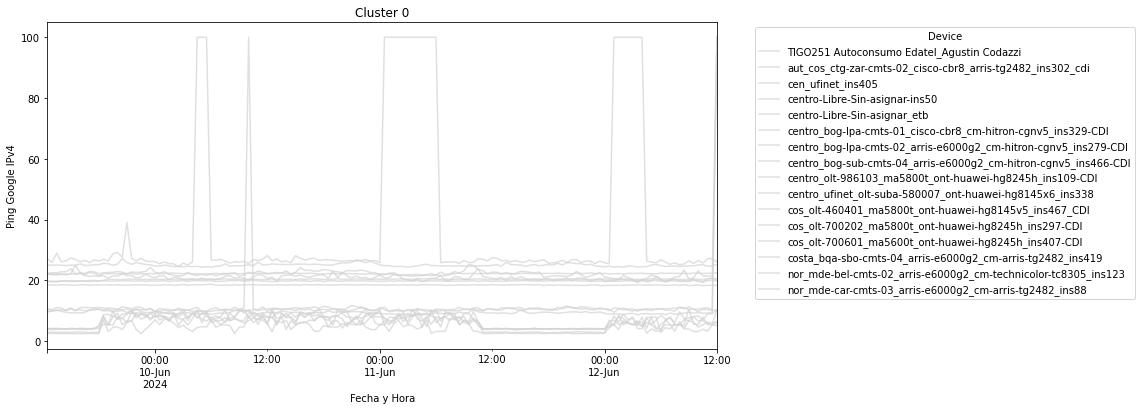

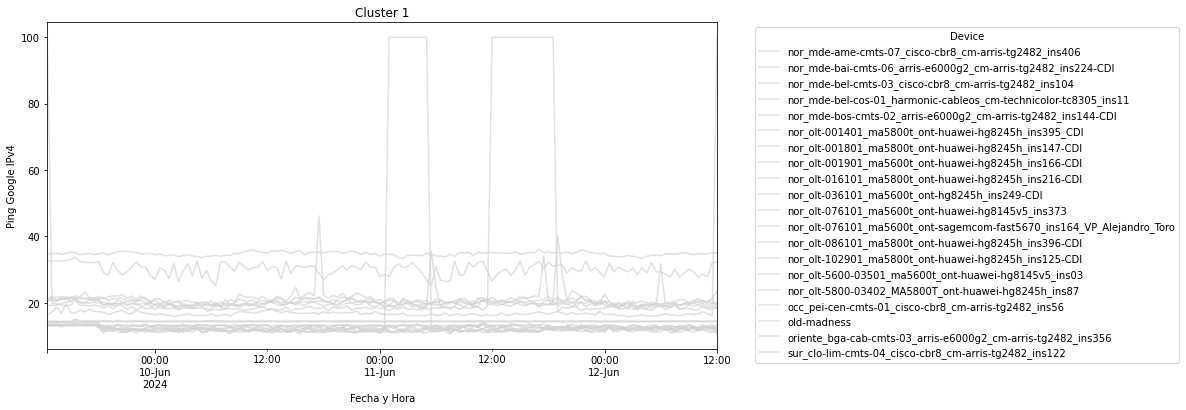

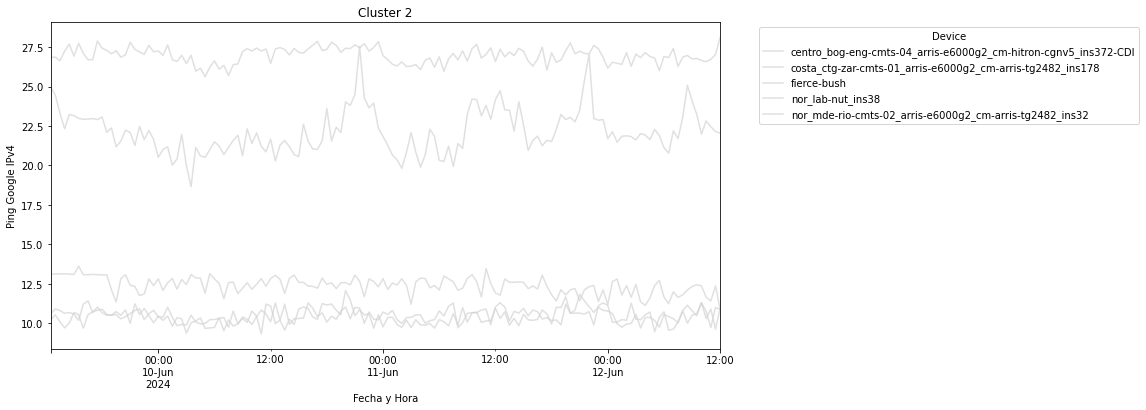

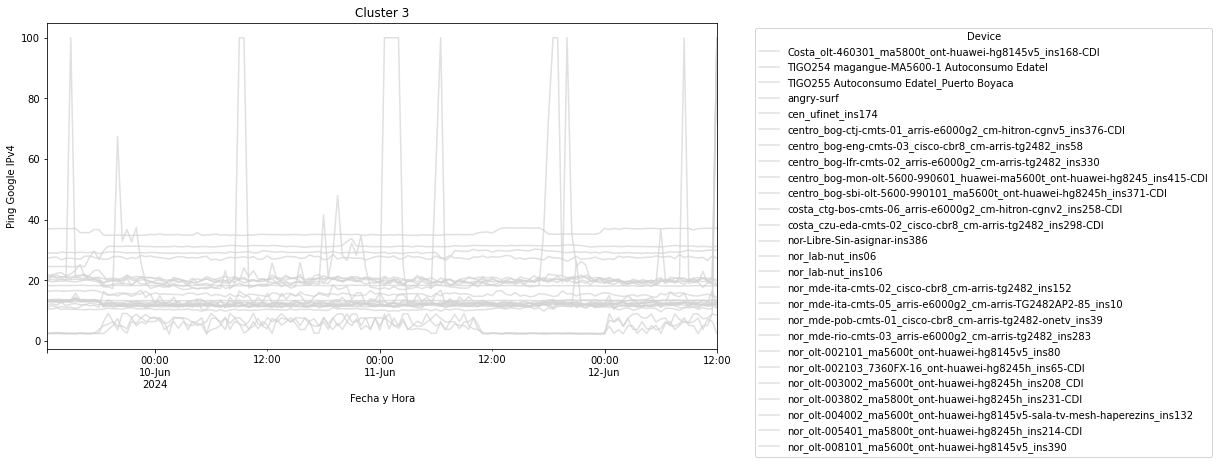

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)


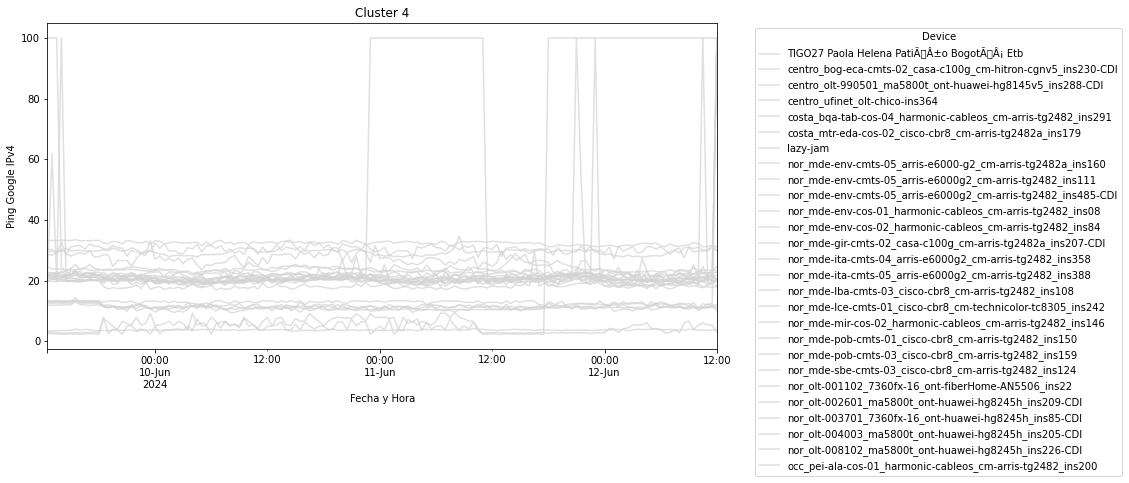

In [31]:
grafica_clusters(clasificados_dict[0], 'Cluster 0')

grafica_clusters(clasificados_dict[1], 'Cluster 1')

grafica_clusters(clasificados_dict[2], 'Cluster 2')

grafica_clusters(clasificados_dict[3], 'Cluster 3')
    
grafica_clusters(clasificados_dict[4], 'Cluster 4')